In [1]:
# warning: current data partitioning with label overrides assumes one object per image

# credit to: https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae
# for initial ideas

# installing key packages:
# conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch -c nvidia

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pycocotools
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
from skimage import transform
import time

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import pandas as pd
import random

from common import parse_kitti, KITTIDataset
import json
import numpy as np

In [4]:
def get_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))        
        transforms.append(T.RandomVerticalFlip(0.5))  
    return T.Compose(transforms)

In [5]:
def get_model(num_classes, pretrained=False):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [6]:
def display_annotation(image, target, label_map, prediction=None, thresh=0, size=None, title=""):
    
    # invert labelmap
    label_map = {v:k for k,v in label_map.items()}
    
    label_offset_x = 0
    label_offset_y = -2
    fig, ax = plt.subplots(figsize=size)   
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # image resize
    #width, height, channels = image.shape
    #image = transform.resize(image, (2*width, 2*height))
    
    ax.imshow(image) # assumes image is a torch.tensor
    
    # ground truth
    boxes = target['boxes']    
    for i in range(boxes.size()[0]):
        x1, y1, x2, y2 = target['boxes'][i]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')    
        ax.add_patch(rect)
        ax.text(x1 + label_offset_x, y1 + label_offset_y, f"{label_map[target['labels'][i].item()]}", color='r')
        if title:
            ax.set_title(title)
        
    # prediction
    if prediction:
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        for i in range(boxes.size()[0]):            
            if scores[i] > thresh:
                x1, y1, x2, y2 = boxes[i]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')    
                ax.add_patch(rect)  
                text = f"{label_map[labels[i].item()]} {scores[i]:.2f}"
                ax.text(x1 + label_offset_x, y2 - 6*label_offset_y, text, color='g')
    plt.show()        

In [7]:
def load_partitions(pattern):
    parts = []
    paths = glob(pattern)
    for p in paths:
        with open(p, 'r') as f:
            parts.append(json.load(f))
    return parts

def train_test_partitions(parts, test_idx):
    p_test = parts[test_idx]
    p_train = []
    for i in range(len(parts)):
        if i != test_idx:
            p_train += parts[i]
    return p_train, p_test

In [8]:
def iou(boxA, boxB):
    # from: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou   

# Data

In [9]:
# experiment name corresponds to the foldername and file prefix for data partitions and label maps
exp_name = "t1-final"

# pattern = f"{exp_name}/{exp_name}-part-*.json"
# partitions = load_partitions(pattern)
# test_fold = 4 # index of the test partition
# data_train, data_test = train_test_partitions(partitions, test_fold)
# print(f"folds: {len(partitions)}, test_fold: {test_fold}, train samples: {len(data_train)}, test samples: {len(data_test)}")

limit = False
# explicit training and test sets
train_path = f"{exp_name}/{exp_name}-part-0.json"
with open(train_path, 'r') as f:
    data_train = json.load(f)
    if limit:
        data_train = data_train[:50]
        print("[WARN] limiting training data")
    
test_path = f"{exp_name}/{exp_name}-test.json"
with open(test_path, 'r') as f:
    data_test = json.load(f)
    if limit:        
        data_test = data_test[:50]
        print("[WARN] limiting test data")
    
print(f"train samples: {len(data_train)}, test samples: {len(data_test)}")

# load the label map
label_map_path = f"{exp_name}/{exp_name}-label-map.json"
with open(label_map_path, 'r') as f:
    label_map = json.load(f)
print(f"label map: {label_map}")
reverse_label_map = {v:k for k,v in label_map.items()}

use_label_overrides = True

train samples: 5804, test samples: 965
label map: {'background': 0, 'rock': 1, 'artefact': 2}


In [10]:
# define datasets and data loaders
batch_size = 16
ds = KITTIDataset(data_train, label_map, use_label_overrides=use_label_overrides, transforms=get_transforms(train=True))
ds_test = KITTIDataset(data_test, label_map, use_label_overrides=use_label_overrides, transforms=get_transforms(train=False))

dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=utils.collate_fn)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=1, collate_fn=utils.collate_fn)

Warning, label overrides assume one object per image
Warning, label overrides assume one object per image


### Data Review

In [ ]:
# check example training image
image, target = ds[random.randrange(len(ds))]
display_annotation(image, target, label_map, size=(5, 5))

In [ ]:
# # check all images
# for i, path in enumerate(ds.img_paths):
#     image, target = ds[i]    
#     display_annotation(image, target, label_map, title=f"[{i}]: {path}")

In [ ]:
# check example test image
image, target = ds_test[random.randrange(len(ds_test))]
display_annotation(image, target, label_map, size=(5, 5))

In [ ]:
# # check all test images
# for i in range(n_test):
#     image, target = ds_test[i]
#     display_annotation(image, target, label_map)

# Evaluation

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
print('device:', device)

device: cuda


In [12]:
# load model
model_path = f"{exp_name}/{exp_name}-model.pt"
loaded_model = get_model(len(label_map))
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device)

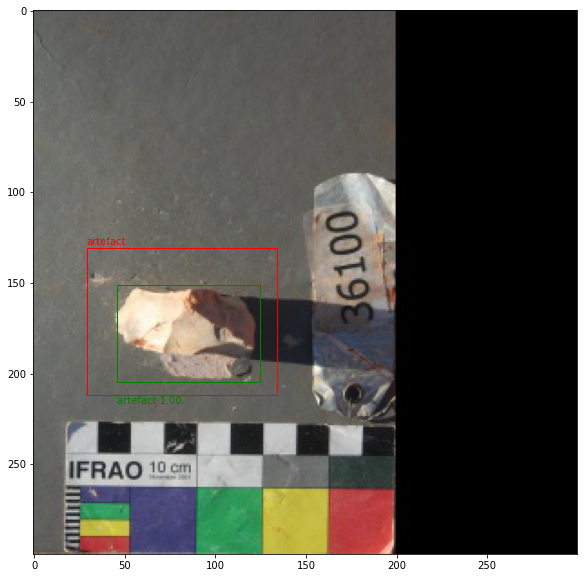

artefact -- 0.9962679743766785
artefact -- 0.09335419535636902


In [13]:
idx = random.randrange(len(ds_test))
#idx = 1
image, target = ds_test[idx]


loaded_model.eval()
with torch.no_grad():
    pred = loaded_model([image.to(device)])    
    display_annotation(image, target, label_map, prediction=pred[0], thresh=0.9, size=(10, 10))
    labels, scores = pred[0]['labels'], pred[0]['scores']
    for i in range(labels.size()[-1]):
        print(reverse_label_map[labels[i].item()], "--", scores[i].item())

In [ ]:
def topn_acc(model, ds, reverse_label_map, n=1, debug=True):
    
    results = np.zeros(len(ds))
    
    model.eval()        
    with torch.no_grad():
        for idx in range(len(ds)):
            image, target = ds[idx]        
            pred = model([image.to(device)])                
            
            # sort predicitons by classifacation score
            labels, scores = pred[0]['labels'], pred[0]['scores']
            pred = list(zip(labels, scores))
            pred.sort(key=lambda x: x[1], reverse=True)
            
            true_label = reverse_label_map[target['labels'][0].item()]
            pred_labels = [reverse_label_map[l.item()] for l, s in pred]
            if debug:
                print(f"true: {true_label}, pred: {[f'{reverse_label_map[l.item()]}: {s:.2f}' for l, s in pred]}")
            
            if true_label in pred_labels[:n]:
                results[idx] = 1
                
    return results            

In [ ]:
def results(model, ds):
    
    records = []
    model.eval()        
    with torch.no_grad():
        for idx in range(len(ds)):
            image, target = ds[idx]        
            pred = model([image.to(device)])            

            # sort predicitons by classifacation score
            labels, scores, boxes = pred[0]['labels'], pred[0]['scores'], pred[0]['boxes']
            pred = list(zip(labels, scores, boxes))
            pred.sort(key=lambda x: x[1], reverse=True)

            true_label = reverse_label_map[target['labels'][0].item()]
            true_box = target['boxes'][0].int().tolist()
            
            pred_labels = [reverse_label_map[l.item()] for l, s, _ in pred]                        
            pred_boxes = [b for _, _, b in pred]
            
            pred_box = pred_boxes[0].int().tolist()
            iou_score = iou(true_box, pred_box)
                                        
            records.append({"image_path": ds.get_image_path(idx), "prediction": pred_labels[0], "IoU": iou_score})
            
    return records


In [ ]:
benchmark_results = results(loaded_model, ds_test)

In [ ]:
# save benchmark results
results_path = f"{exp_name}/{exp_name}-benchmark-results.json"
with open(results_path, 'w') as f:
    json.dump(benchmark_results, f)    